In [49]:
%matplotlib inline
import pandas as pd
from scipy import stats
import seaborn as sns

import numpy as np
from collections import Counter

In [50]:
data=pd.read_csv("data/clean.csv")

In [51]:
df=data.copy()

In [52]:
numeric = []
qualitative= []

for variable in df.columns.tolist():
    if df.dtypes[variable] in ['float64','int64']:
        numeric.append(variable)
    else :
        qualitative.append(variable)

##### Test de normalité

In [53]:
def shapiro_test(x):
    try :
        res = stats.shapiro(x)
    except :
        return -1
    alpha = 0.05

    print("p = ",res.pvalue)

    if res.pvalue < alpha:  # null hypothesis: x comes from a normal distribution

        print("(shapiro)The null hypothesis can be rejected -> X ne possède pas une distribution normale")

    else:

        print("(shapiro) The null hypothesis cannot be rejected -> X possède éventuellement une distribution normale")

    return res

def omnibus_normaltest(x):
    #test D'Agostino-Pearson
    try :
        k2, p = stats.normaltest(x)
    except :
        return -1

    alpha = 0.05

    print("p = ",p)

    if p < alpha:  # null hypothesis: x comes from a normal distribution

        print("(normaltest) The null hypothesis can be rejected -> X ne possède pas une distribution normale")

    else:

        print("(normaltest) The null hypothesis cannot be rejected -> X possède éventuellement une distribution normale")

    return [k2,p]

## valeur missing

In [71]:
def missing(df):
    df_null = pd.DataFrame([df.isnull().sum(),round(100*df.isnull().sum()/ len(df), 2), df.dtypes]).transpose().reset_index()
    df_null.columns = ["variable", "valeur_NA", "Pourcentage_NA", "type"]
    df_null = df_null[df_null.valeur_NA != 0].sort_values("valeur_NA",ascending = False).reset_index(drop = True)
    return df_null
missing(df)

,variable,valeur_NA,Pourcentage_NA,type


In [55]:
list(data.columns[data.isnull().sum() / len(data) > 0.75])

['division_af']

In [56]:
d=data.copy()
df = d.drop('division_af',axis=1)

In [57]:
d=list(data.columns[data.isnull().sum() / len(data) < 0.05])
for i in list(d):
    df = df.dropna(subset=[i], axis=0)
missing(df)

,variable,valeur_NA,Pourcentage_NA,type
0,fonction_af,10060,67.15,object
1,ann_dipl,8394,56.03,float64
2,date_ps,8380,55.93,float64
3,direction_af,8194,54.69,object
4,motif_affect,7666,51.17,object
5,service_af,6794,45.35,object
6,job_act,2965,19.79,object
7,dt_echeance,2927,19.54,float64


In [58]:
df['fonction_af'] = df['fonction_af'].fillna(df['fonction_af'].mode()[0])
df['direction_af'] = df['direction_af'].fillna(df['direction_af'].mode()[0])
df['motif_affect'] = df['motif_affect'].fillna(df['motif_affect'].mode()[0])
df['service_af'] = df['service_af'].fillna(df['service_af'].mode()[0])
df['job_act'] = df['job_act'].fillna(df['job_act'].mode()[0])

d=list(df.columns[df.isnull().sum() / len(df) < 0.05])
for i in list(d):
    df = df.dropna(subset=[i], axis=0)

from sklearn.impute import KNNImputer
df[numeric]=KNNImputer(missing_values=np.nan, n_neighbors=3).fit_transform(df[numeric])
df[numeric] = np.round(df[numeric],decimals = 0)

In [59]:
missing(df)

,variable,valeur_NA,Pourcentage_NA,type


<AxesSubplot:>

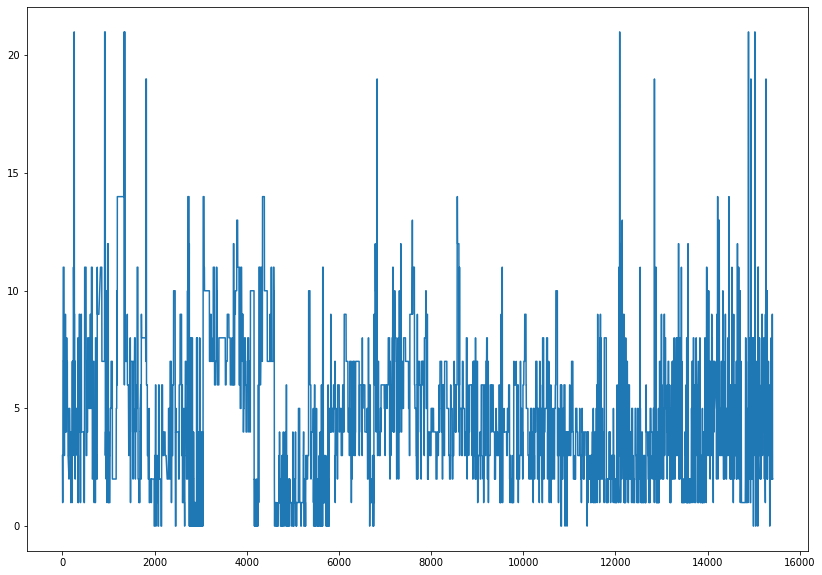

In [60]:
df['tot_afct'].plot(figsize=(14,10))

## Valeur aberante

In [61]:
# Outlier detection

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

Outliers_to_drop = detect_outliers(df,0,numeric)
# df.drop(Outliers_to_drop,0,inplace=True)
len(Outliers_to_drop)

3136

## Teste de normalite

In [62]:
# Shapiro-Wilk Test
from scipy.stats import shapiro
def Shapiro(d):
    stat, p = shapiro(d)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

for i in numeric:
    print(i)
    Shapiro(df[i])

age
Statistics=0.974, p=0.000
Sample does not look Gaussian (reject H0)
job_ok
Statistics=0.093, p=0.000
Sample does not look Gaussian (reject H0)
nbre_enf
Statistics=0.888, p=0.000
Sample does not look Gaussian (reject H0)
ann_dipl
Statistics=0.092, p=0.000
Sample does not look Gaussian (reject H0)
ordre
Statistics=0.845, p=0.000
Sample does not look Gaussian (reject H0)
annee_ent
Statistics=0.884, p=0.000
Sample does not look Gaussian (reject H0)
date_ent
Statistics=0.883, p=0.000
Sample does not look Gaussian (reject H0)
date_ps
Statistics=0.867, p=0.000
Sample does not look Gaussian (reject H0)
dat_retraite
Statistics=0.978, p=0.000
Sample does not look Gaussian (reject H0)
dt_echeance
Statistics=0.770, p=0.000
Sample does not look Gaussian (reject H0)
tot_afct
Statistics=0.933, p=0.000
Sample does not look Gaussian (reject H0)


c:\users\kitty\pycharmprojects\testaffichage\venv\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [63]:
from scipy.stats import normaltest
def agostino_test(d):
    stat, p = normaltest(d)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

for i in numeric:
    agostino_test(df[i])

Statistics=658.138, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=20436.859, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=2869.009, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=39184.341, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=3758.679, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=2287.395, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=2362.225, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=5036.362, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=381.297, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=6657.064, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=2564.884, p=0.000
Sample does not look Gaussian (reject H0)


In [64]:
p_values = {}
for col in numeric:
    print("\n",col)
    Shapiro(np.log(df[col].dropna()))


 age
Statistics=0.981, p=0.000
Sample does not look Gaussian (reject H0)

 job_ok
Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)

 nbre_enf
Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)

 ann_dipl
Statistics=0.020, p=0.000
Sample does not look Gaussian (reject H0)

 ordre
Statistics=0.924, p=0.000
Sample does not look Gaussian (reject H0)

 annee_ent
Statistics=0.735, p=0.000
Sample does not look Gaussian (reject H0)

 date_ent
Statistics=0.868, p=0.000
Sample does not look Gaussian (reject H0)

 date_ps
Statistics=0.853, p=0.000
Sample does not look Gaussian (reject H0)

 dat_retraite
Statistics=0.971, p=0.000
Sample does not look Gaussian (reject H0)

 dt_echeance
Statistics=0.507, p=0.000
Sample does not look Gaussian (reject H0)

 tot_afct
Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)


c:\users\kitty\pycharmprojects\testaffichage\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [65]:
len(df[qualitative[4]].unique())

6

In [66]:
formation=['ECONOMIE CIRCULAIRE ET DEVELOPPEMENT DURABLE','CFEPENN','2EME REUNION DES EXPERTS DE','AGOA','FORMATION','SCANNER','RAPPROCHEMENT DES DONNEES COMPTABLES','RENFORCEMENT','SEMINAIRE','LUTTE','SURVEILLANCE','ATELIER','TECHNIQUE D\'ENQUETE','SCANNER','DACTYLOGRAPHIE','FOOD SAFETY INSPECTION TECHNOLOGY','COMMUNICATION INTERPERSONNELLE','ACCUEIL DES USAGERS','SURETE AEROPORTUAIRE','ATELIER SUR LES NEGOCIATIONS SUR LA ZLET TRIPARTITE','VALEUR TRANSACTIONNELLE','COMPTABILITE','BAE','MECANICIEN','CONTROLE A POSTERIORI','OPERATEUR IMAGE SCANNER','TABLEAU DE BORD','CORRESPONDANCE ADMINISTRATIVE','ATTACHE D\'ADMINISTRATION','REGLES D\'ORIGINE','SECRETARIAT','TEAM MANAGEMENT','DEVELOPPEMENT PERSONNEL','GESTION AXEE SUR LES RESULTATS','SECRETARIAT','MISE A NIVEAU','MECANIQUE AUTOMOBILE','MANAGEMENT ET LEADERSHIP','BUREAUTIQUE','LEADERSHIP','FORMATION']
MAITRISE=['DUES','4E ANNEE','BACC+4','BACC+5','SECOND CYCLE',"DIPLOME D'ETUDES PROFESSIONNELLES APPROFONDIES",'4EME ANNEE','MASTER','MAITRISE','ETHIQUE ET DEONTOLOGIE','DEA','MAGISTERE','INGENIORAT','INGENIEUR','2ND CYCLE','BACCALAUREAT+4']
LICENCE =['3EME ANNEE','BACC+3','LICENCE']
BREVET=['BREVET','CFEPCES','PREBAC','PRE BAC','BEPC']
PRIMAIRE=['CAE/EB','CEPE','CERTIFICAT D\'ETUDES PRIMAIRES ELEMENTAIRES']
DOUANE=['SYDONIA++','PROCEDURE DE DEDOUANEMENT','DOUAN','TRANSIT']
LANGUES=['B1-B2','ANGLAIS','FRANCAIS','DELF','ENGLISH','MTCP']
INFORMATIQUE=['ANALYSE D\'IMAGE','ATTESTATION','ELECTRONIQUE','ELECTROTECHNIQUE','PROGRAMMATION','DEVELOPPEUR','SOFTWARE','BASE DE DONNEE','ORACLE','EXCEL','WEB','LINUX','GRAPHISTE','RESEAU','INFORMATIQUE','PROGRAMMEUR']
PERMIS=['PERMIS','MAINTENANCE AUTOMOBILE','CHAUFFEUR','MECANIQUE AUTO','CONDUCTEUR']
BACC=['BACC','BACALAUREAT']
SUPERIEUR=['BT','BATIMENT','COMPTABLE','AUDIT INTERNE','DROIT','GESTION','DROIT / GEOGRAPHIE','MANAGEMENT','DIPLOME','INFA','IST-T','COMMUNICATION','SUPERIEUR','UNIVERSITAIRE','COACHING','CHEF','BANCAIRES','INTERNATIONALES','ETUDES APPROFONDIES','SERVICE NATIONAL HORS FORCES ARMEES','RADIOPROTECTION','ETUDES JUDICIAIRES','CONTROLE A LA CIRCULATION','MARCHE PUBLIC','ENVIRONNEMENT','OZONE','SURETE AEROPORTUAIRE ET FRAUDE DOCUMENTAIRE','SUBSTANCES APPAUVRISSANT LA COUCHE D\'OZONE','COMMERCE INTERNATIONAL','CITES','CONTROLE DES SUBSTANCES APPAUVRISSANT LA COUCHE D\'OZONE','DIPLOME D\'ATTACHE D\'ADMINISTRATION']
DTS=['2E ANNEE','DEUG','2EME ANNEE','BACC+2','DTS']
Autres=['FORMATION','MAITRISE','LICENCE','BREVET','PRIMAIRE','DOUANE','LANGUES','INFORMATIQUE','PERMIS','BACC','SUPERIEUR','DTS']
dat = list(df[qualitative[4]])
for index, value in enumerate(dat):
    for i in DTS:
        if i in str(value):
            dat[index]='DTS'
    for i in BACC:
        if i in str(value):
            dat[index]='BACC'
    for i in SUPERIEUR:
        if i in str(value):
            dat[index]='SUPERIEUR'
    for i in PERMIS:
        if i in str(value):
            dat[index]='PERMIS'
    for i in INFORMATIQUE:
        if i in str(value):
            dat[index]='INFORMATIQUE'
    for i in LANGUES:
        if i in str(value):
            dat[index]='LANGUES'
    for i in DOUANE:
        if i in str(value):
            dat[index]='DOUANE'
    for i in PRIMAIRE:
        if i in str(value):
            dat[index]='PRIMAIRE'
    for i in BREVET:
        if i in str(value):
            dat[index]='BREVET'
    for i in LICENCE:
        if i in str(value):
            dat[index]='LICENCE'
    for i in formation:
        if str(i) in str(value):
            dat[index]='FORMATION'
    for i in MAITRISE:
        if i in str(value):
            dat[index]='MAITRISE'
    if 'CERTIFICAT' in str(value):
        dat[index]='CERTIFICAT'
    if 'DOCTORAT' in str(value):
        dat[index]='DOCTORAT'

df[qualitative[4]] =  dat
d = list(df[qualitative[4]])
for index, value in enumerate(d):
    if  str(value) not in Autres:
        print(value)
        d[index]='Autres'
df[qualitative[4]] =  d


CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
CERTIFICAT
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
CERTIFICAT
CERTIFICAT
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
CERTIFICAT
CERTIFICAT
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
CERTIFICAT
CERTIFICAT
APTITUDE PROFESSIONNEL
CERTIFICAT
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
CERTIFICAT
CERTIFICAT
APTITUDE PROFESSIONNEL
APTITUDE PROFESSIONNEL
APTITUDE PR

In [67]:
def processPerLevels(data,list_feature):
    catHead = ['Feature', 'Level', 'Count', 'Frequence %']
    count = []
    freq = []
    feature_all = []
    list_level_all = []
    for feature in list_feature:

        list_level = data[feature].unique().tolist()

        len_level = len(list_level)

        for level in list_level:
            count_level = len(data.loc[data[feature] == level])
            count.append(count_level)
            freq_level = count_level * 100/len(data)
            freq.append(round(freq_level, 2))
            feature_all.append(feature)
            list_level_all.append(level)

    resultDf = pd.DataFrame(columns=catHead)
    resultDf['Level'] = list_level_all
    resultDf['Feature'] = feature_all
    resultDf['Count'] = count
    resultDf['Frequence %'] = freq
    resultDf.set_index(['Feature', 'Level'], inplace=True)
    return resultDf
processPerLevels(df,[qualitative[4]])

Count  Frequence %
Feature Level                           
nature  SUPERIEUR      9159        61.13
        Autres         4735        31.60
        FORMATION       671         4.48
        INFORMATIQUE    417         2.78

In [68]:
print(len(df[qualitative[15]].unique()))
processPerLevels(df,[qualitative[15]])

60


Count  Frequence %
Feature   Level                     
poste_act 22TP      394         2.63
          21TO     1492         9.96
          25BT      196         1.31
          11AN     1409         9.40
          35NB      225         1.50
          SAE        72         0.48
          13AB      179         1.19
          DGD       421         2.81
          31AH       52         0.35
          SLF       834         5.57
          SRH       219         1.46
          SI        215         1.44
          34AS      137         0.91
          33VO      146         0.97
          14MA      874         5.83
          12IV     1873        12.50
          42MG      614         4.10
          54TG       84         0.56
          32SA       97         0.65
          DSE       140         0.93
          DRF       247         1.65
          SAJC      302         2.02
          SCAP      155         1.03
          SID       199         1.33
          SRAR      288         1.92
          PRMP       52         0.35
          ILMAU      24         0.16
          SLR       428         2.86
          63FI      244         1.63
          53TL      200         1.33
          SDC       136         0.91
          CDL       109         0.73
          BSTNR     189         1.26
          CPERF      44         0.29
          BSTMM     399         2.66
          SPCB      198         1.32
          DAJLF      47         0.31
          SE        160         1.07
          SVO       208         1.39
          SF        234         1.56
          SSLC      484         3.23
          SRI        87         0.58
          61MK       46         0.31
          SCSR      200         1.33
          62MJ       15         0.10
          GNV         9         0.06
          SSOC       87         0.58
          DSCD       94         0.63
          DLV       109         0.73
          PRS        25         0.17
          BRX        37         0.25
          51MD       92         0.61
          24SM        4         0.03
          SSAE       60         0.40
          PSMJG       3         0.02
          AUTRES     81         0.54
          23MA        3         0.02
          PSTUL       2         0.01
          PSTAO       6         0.04
          PSNSB       2         0.01

## log

## Stendardisation

In [69]:
df.to_csv(r'data/preproce.csv',index=False)
